In [1]:
# import statements including namaster python wrapper
import numpy as np
import healpy as hp
import pymaster as nmt
import pysm3
import pysm3.units as u
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import warnings
warnings.filterwarnings("ignore")

In [2]:
# matplotlib formatting stuff
rc('text', usetex=True)
res_dpi = 300
ext = 'pdf'

In [3]:
# function that takes in a frequency and and makes a map
def make_map(freq):
    return sky.get_emission(freq * u.GHz) 

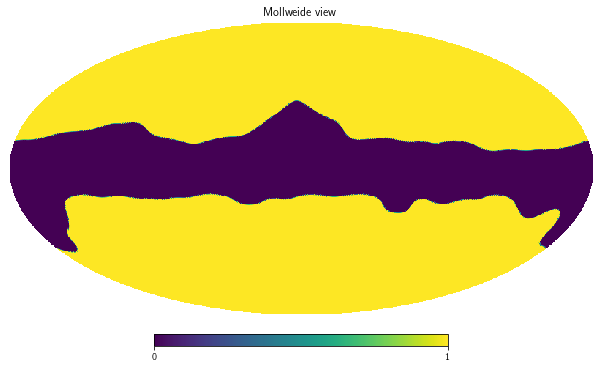

In [4]:
# HEALPix resolution parameter
nside = 128
# initialize binning scheme with 10 ells per bandpower
b = nmt.NmtBin.from_nside_linear(nside, 10)
# read planck mask (GAL070) and lower resolution to nside=128
mask = hp.read_map("HFI_Mask_GalPlane-apo0_2048_R2.00.fits", field=3)
mask_128 = hp.pixelfunc.ud_grade(mask, 128)
hp.mollview(mask_128)

In [5]:
# save mask
hp.write_map("mask_GAL070_128.fits", mask_128)

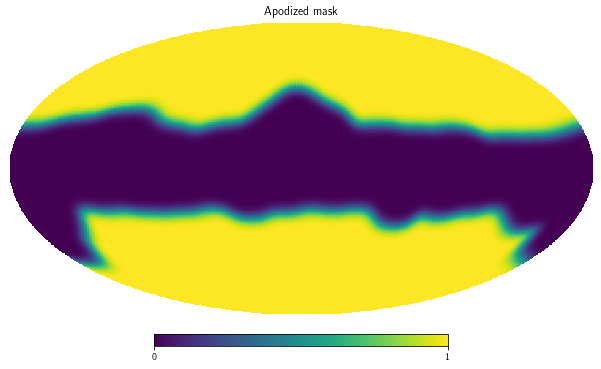

In [6]:
# read mask and apodize it on a scale of ~3degs
mask = nmt.mask_apodization(hp.read_map("mask_GAL070_128.fits", verbose=False), 3., apotype="Smooth")
hp.mollview(mask, title='Apodized mask')

In [7]:
# function that takes in a map, the map_150, the clbb1x1 value, and the map 150 field and outputs rbb80 value
def rbb80(map2, map_150, clbb1x1, f2_map150):
    # initialize spin-2 field for map2
    f2_map2 = nmt.NmtField(mask, map2[1:,:], purify_b = True)
    clbb1x2 = nmt.compute_full_master(f2_map150, f2_map2, b)[3][8]
    clbb2x2 = nmt.compute_full_master(f2_map2, f2_map2, b)[3][8]
    return clbb1x2/(np.sqrt(clbb1x1*clbb2x2))

In [8]:
freqs = np.arange(150,3000,150)
rbb80_vals = np.ones((len(freqs),9))*1.
# for all of the models
for i in range(9):
    # make a sky
    sky = pysm3.Sky(nside=128, preset_strings=["d"+str(i)])
    # make 150GHz map
    map_150GHz = sky.get_emission(150 * u.GHz)
    # initialize a spin-2 field, compute it's clbb80 value
    f2_map150 = nmt.NmtField(mask, map_150GHz[1:,:], purify_b = True)
    clbb1x1 = nmt.compute_full_master(f2_map150, f2_map150, b)[3][8]
    # compute RlBB[80] for every 150GHz from 150GHz to 3THz
    for j, freq in enumerate(freqs):
        rbb80_vals[j][i] = (1 - rbb80(make_map(freq), map_150GHz, clbb1x1, f2_map150))

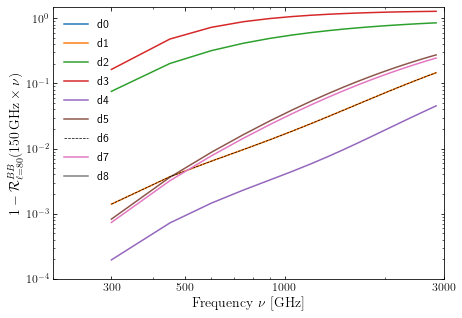

In [9]:
fig, ax = plt.subplots(1,1,figsize=(7, 5))
ax.set_xscale('log')
ax.set_xlabel(r'${\rm Frequency}\ \nu\ [{\rm GHz}]$', fontsize=14)
ax.set_yscale('log')
ax.set_ylabel(r'$1 - \mathcal{R}^{BB}_{\ell=80} (150\,{\rm GHz}\times\nu)$', fontsize=14)
ax.axis([200, 3000.,  1e-4, 1.5])
ax.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis='both', which='both', labelsize=12, bottom=True, top=True, left=True, right=True, direction='in')
ax.set_xticks([300, 500, 1000, 3000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

models = np.array([0,1,2,3,4,5,6,7,8])
for i, model in enumerate(models):
    if i == 6:
        ax.plot(freqs[1:], rbb80_vals[1:,6], label= 'd'+str(i), linestyle='--', color='k', linewidth = 0.7)
    else:
        ax.plot(freqs[1:], rbb80_vals[1:,i], label= 'd'+str(i))
ax.legend(frameon=False, prop={'size': 12})
plt.savefig('rbb_mask.' + ext,format=ext,dpi=res_dpi,bbox_inches='tight')